In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
# cd drive/MyDrive/IE7500_GroupB/Notebooks

In [9]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [15]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 18.4 MB/s eta 0:00:00a 0:00:01


In [3]:
# load necesary libraries
import numpy as np
import pandas as pd

In [4]:
dtypes_dict = {'headline': 'object',
               'url': 'object',
               'publisher': 'object',
               'stock': 'object',
               'tokens': 'object',
               'normalized_tokens': 'object',
               'filtered_tokens': 'object',
               'lemmas': 'object',
               'sentiment_score': 'float64',
               'Name': 'object',
               'Market Cap': 'float64',
               'Country': 'object',
               'IPO Year': 'float64',
               'Sector': 'object',
               'Industry': 'object',
               'year': 'int32',
               'month': 'int32',
               'day_of_week': 'int32',
               'sentiment_label': 'int64',
               'headline_length': 'int64',
               'word_count': 'int64',
               'Market_Cap_Category': 'object',
               'recommendation': 'object',
               'cap_Large': 'bool',
               'cap_Medium': 'bool',
               'cap_Mega': 'bool',
               'cap_Micro': 'bool',
               'cap_Nano': 'bool',
               'cap_Small': 'bool',
               'sector_Basic Materials': 'bool',
               'sector_Consumer Discretionary': 'bool',
               'sector_Consumer Staples': 'bool',
               'sector_Energy': 'bool',
               'sector_Finance': 'bool',
               'sector_Health Care': 'bool',
               'sector_Industrials': 'bool',
               'sector_Miscellaneous': 'bool',
               'sector_Real Estate': 'bool',
               'sector_Technology': 'bool',
               'sector_Telecommunications': 'bool',
               'sector_Utilities': 'bool', 'recommendation_label': 'int64',
               'publisher_label': 'int64', 'country_label': 'int64',
               'industry_label': 'int64'}

In [5]:
# load dataframes to use
df_main = pd.read_csv("saved_dfs/df_for_models.csv", dtype=dtypes_dict,
                      parse_dates=['date'])

In [6]:
df_main.head()

,headline,url,publisher,date,stock,tokens,normalized_tokens,filtered_tokens,lemmas,sentiment_score,...,sector_Industrials,sector_Miscellaneous,sector_Real Estate,sector_Technology,sector_Telecommunications,sector_Utilities,recommendation_label,publisher_label,country_label,industry_label
0,Agilent Technologies Announces Pricing of $5……...,http://www.gurufocus.com/news/1153187/agilent-...,GuruFocus,2020-06-01,A,"['Agilent', 'Technologies', 'Announces', 'Pric...","['agilent', 'technologies', 'announces', 'pric...","['agilent', 'technologies', 'announces', 'pric...","['agilent', 'technology', 'announces', 'pricin...",0.0000,...,True,False,False,False,False,False,1,4,45,18
1,Agilent (A) Gears Up for Q2 Earnings: What's i...,http://www.zacks.com/stock/news/931205/agilent...,Zacks,2020-05-18,A,"['Agilent', '(', 'A', ')', 'Gears', 'Up', 'for...","['agilent', 'a', 'gears', 'up', 'for', 'q2', '...","['agilent', 'gears', 'q2', 'earnings', 'cards']","['agilent', 'gear', 'q2', 'earnings', 'card']",0.0000,...,True,False,False,False,False,False,1,16,45,18
2,J.P. Morgan Asset Management Announces Liquida...,http://www.gurufocus.com/news/1138923/jp-morga...,GuruFocus,2020-05-15,A,"['J.P.', 'Morgan', 'Asset', 'Management', 'Ann...","['morgan', 'asset', 'management', 'announces',...","['morgan', 'asset', 'management', 'announces',...","['morgan', 'asset', 'management', 'announces',...",0.3612,...,True,False,False,False,False,False,1,4,45,18
3,"Pershing Square Capital Management, L.P. Buys ...",http://www.gurufocus.com/news/1138704/pershing...,GuruFocus,2020-05-15,A,"['Pershing', 'Square', 'Capital', 'Management'...","['pershing', 'square', 'capital', 'management'...","['pershing', 'square', 'capital', 'management'...","['pershing', 'square', 'capital', 'management'...",0.0000,...,True,False,False,False,False,False,1,4,45,18
4,Agilent Awards Trilogy Sciences with a Golden ...,http://www.gurufocus.com/news/1134012/agilent-...,GuruFocus,2020-05-12,A,"['Agilent', 'Awards', 'Trilogy', 'Sciences', '...","['agilent', 'awards', 'trilogy', 'sciences', '...","['agilent', 'awards', 'trilogy', 'sciences', '...","['agilent', 'award', 'trilogy', 'science', 'go...",0.4588,...,True,False,False,False,False,False,1,4,45,18


# Goal 3: ML Trading Bot

## SETUP

In [8]:
# === GOAL 3: Setup for NLP-Based Trading Bot Models ===

# 1. Define text and target
text_column = 'headline'
X_text = df_main[text_column].fillna('').astype(str)
y = df_main['recommendation_label']

# 2. Train/test split
from sklearn.model_selection import train_test_split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Optional structured features for hybrid models
structured_features = [
    'sentiment_score', 'headline_length', 'word_count',
    'cap_Large', 'cap_Medium', 'cap_Small',
    'sector_Technology', 'sector_Finance', 'sector_Health Care'
]

X_structured = df_main[structured_features]
X_train_struct, X_test_struct = train_test_split(
    X_structured, test_size=0.2, stratify=y, random_state=42
)

# 4. TF-IDF vectorization (for MLP or XGBoost)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

# 5. Tokenizer (for LSTM)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)
max_len = 30
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

# 6. One-hot encode labels (for Keras models)
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
num_classes = y_train_cat.shape[1]


2025-04-20 15:42:53.528054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745178173.548573 1303934 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745178173.554777 1303934 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745178173.571206 1303934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745178173.571221 1303934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745178173.571224 1303934 computation_placer.cc:177] computation placer alr

## Method 1: XGBoost

In [11]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

xgb_pipeline = Pipeline([
    ("clf", XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42
    ))
])

xgb_pipeline.fit(X_train_vec, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test_vec)
print("XGBoost Performance on Headlines:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

XGBoost Performance on Headlines:
              precision    recall  f1-score   support

           0       0.93      0.55      0.69     36913
           1       0.93      0.99      0.96    317698
           2       0.92      0.40      0.55     14501

    accuracy                           0.93    369112
   macro avg       0.92      0.65      0.73    369112
weighted avg       0.93      0.93      0.92    369112



## Method 2: LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Define and train fine-tuned LightGBM model
lgbm_model = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.3,
    random_state=42
)

lgbm_model.fit(
    X_train_vec, y_train,
    eval_set=[(X_test_vec, y_test)],
    eval_metric="multi_logloss"
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.724529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280221
[LightGBM] [Info] Number of data points in the train set: 1476447, number of used features: 5000
[LightGBM] [Info] Start training from score -2.302549
[LightGBM] [Info] Start training from score -0.149999
[LightGBM] [Info] Start training from score -3.236847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

In [25]:
# Predict and evaluate
y_pred_lgbm = lgbm_model.predict(X_test_vec)
print("LightGBM Classifier Performance on Headlines:")
print(classification_report(y_test, y_pred_lgbm, zero_division=0))

/courses/IE7500.202530/shared/conda_env_1/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Classifier Performance on Headlines:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77     36913
           1       0.94      0.99      0.97    317698
           2       0.91      0.58      0.71     14501

    accuracy                           0.94    369112
   macro avg       0.93      0.75      0.82    369112
weighted avg       0.94      0.94      0.94    369112



## Method 3: FinBERT + SGDClassifier for Trading Bot

In [33]:
!pip install -q sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
import numpy as np

In [35]:
# 2. Load sentence-transformers FinBERT (optimized for speed)
model = SentenceTransformer("yiyanghkust/finbert-tone")

# 3. Encode headlines (X_train_text and X_test_text from setup)
X_train_finbert = model.encode(X_train_text.tolist(), batch_size=32, show_progress_bar=True)
X_test_finbert = model.encode(X_test_text.tolist(), batch_size=32, show_progress_bar=True)

# 4. Train classifier
clf = SGDClassifier(loss="log_loss", max_iter=1000, random_state=42)
clf.fit(X_train_finbert, y_train)

# 5. Predict and evaluate
y_pred = clf.predict(X_test_finbert)
print("FinBERT (sentence-transformers) + SGDClassifier Performance:")
print(classification_report(y_test, y_pred, zero_division=0))

No sentence-transformers model found with name yiyanghkust/finbert-tone. Creating a new one with mean pooling.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Batches:   1%|          | 325/46139 [02:16<5:21:03,  2.38it/s]


KeyboardInterrupt: 

In [ ]:
# 6. Map predictions to trade actions
def map_to_action(pred):
    return {0: "SELL", 1: "HOLD", 2: "BUY"}.get(pred, "UNKNOWN")

actions = [map_to_action(p) for p in y_pred]
print("Predicted trade actions:", actions[:10])

In [40]:
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
import torch
import numpy as np
from tqdm import tqdm

# 1. Load FinBERT (pretrained by ProsusAI or ipuneetrathore)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModel.from_pretrained("ProsusAI/finbert")
model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. Batched FinBERT encoding
def finbert_encode_batched(texts, tokenizer, model, batch_size=32, max_len=30):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding with FinBERT"):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_len)
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
# 3. Encode headlines
X_train_finbert = finbert_encode_batched(X_train_text.tolist(), tokenizer, model)
X_test_finbert = finbert_encode_batched(X_test_text.tolist(), tokenizer, model)

# 4. Train SGDClassifier
clf = SGDClassifier(loss="log_loss", max_iter=1000, random_state=42)
clf.fit(X_train_finbert, y_train)

# 5. Predict and evaluate
y_pred = clf.predict(X_test_finbert)
print("FinBERT + SGDClassifier Performance:")
print(classification_report(y_test, y_pred, zero_division=0))

# 6. Map predictions to actions
def map_to_action(pred):
    return {0: "SELL", 1: "HOLD", 2: "BUY"}.get(pred, "UNKNOWN")

print("Predicted trade actions:", [map_to_action(p) for p in y_pred[:10]])

Encoding with FinBERT: 100%|██████████| 11535/11535 [28:32<00:00,  6.73it/s]


FinBERT + SGDClassifier Performance:
              precision    recall  f1-score   support

           0       0.72      0.27      0.39     36913
           1       0.89      0.99      0.94    317698
           2       0.83      0.26      0.40     14501

    accuracy                           0.89    369112
   macro avg       0.81      0.51      0.58    369112
weighted avg       0.87      0.89      0.86    369112

Predicted trade actions: ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD']


## Method 4: Reinforcement Learning (DQN) for ML Trading Bot


In [28]:
!pip install stable-baselines3[extra] gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [29]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

# Features for the RL environment
features = ["sentiment_score", "publisher_label", "country_label", "industry_label",
            "sector_Industrials", "sector_Miscellaneous", "sector_Real Estate",
            "sector_Technology", "sector_Telecommunications", "sector_Utilities"]

# Prepare feature data
rl_df = df_main[features].fillna(0).reset_index(drop=True)


In [30]:
class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.initial_balance = 1000.0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.n_steps = len(df)

        # Actions: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)
        # Observations: all features (shape = number of columns)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(df.shape[1],), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        return self.df.iloc[self.current_step].values.astype(np.float32)

    def step(self, action):
        done = False
        current_price = self.df.iloc[self.current_step]["sentiment_score"] + 1  # Simulated price
        reward = 0

        # Execute Buy
        if action == 1 and self.balance >= current_price:
            self.shares_held += 1
            self.balance -= current_price
        # Execute Sell
        elif action == 2 and self.shares_held > 0:
            self.shares_held -= 1
            self.balance += current_price
            reward = current_price - 1  # Assume base cost = 1

        # Go to next step
        self.current_step += 1
        if self.current_step >= self.n_steps - 1:
            done = True

        obs = self.df.iloc[self.current_step].values.astype(np.float32)
        return obs, reward, done, {}

    def render(self, mode="human"):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}")


In [32]:
!pip install 'shimmy>=2.0'

In [33]:
# Wrap the custom environment using DummyVecEnv
env = DummyVecEnv([lambda: TradingEnv(rl_df)])


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [34]:
# Initialize and train the DQN agent
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)


Using cpu device


In [35]:
obs = env.reset()
total_reward = 0

for _ in range(len(rl_df) - 1):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    if done:
        break

print(f"Total Reward from DQN Agent: {total_reward}")

Total Reward from DQN Agent: [20697.22]


In [36]:
# Save the model
model.save("dqn_trading_bot")
print("Model saved as dqn_trading_bot.zip")

Model saved as dqn_trading_bot.zip


## Method 5: LSTM for Time Series Forecasting

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [38]:
# Use sentiment_score as proxy for "price" or signal
data = df_main["sentiment_score"].fillna(0).values.reshape(-1, 1)

# Scale data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for supervised learning
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 10
X_seq, y_seq = create_sequences(scaled_data, sequence_length)

# Split into training and test sets (80/20)
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

In [39]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train LSTM model, use 5 epochs to save time
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
46139/46139 ━━━━━━━━━━━━━━━━━━━━ 346s 7ms/step - loss: 0.0225 - val_loss: 0.0232
Epoch 2/5
46139/46139 ━━━━━━━━━━━━━━━━━━━━ 370s 7ms/step - loss: 0.0224 - val_loss: 0.0232
Epoch 3/5
46139/46139 ━━━━━━━━━━━━━━━━━━━━ 382s 7ms/step - loss: 0.0224 - val_loss: 0.0231
Epoch 4/5
46139/46139 ━━━━━━━━━━━━━━━━━━━━ 344s 7ms/step - loss: 0.0224 - val_loss: 0.0232
Epoch 5/5
46139/46139 ━━━━━━━━━━━━━━━━━━━━ 337s 7ms/step - loss: 0.0224 - val_loss: 0.0232


In [42]:
# Predict on test data
y_pred = lstm_model.predict(X_test)

# Inverse scale predictions and ground truth
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"LSTM Test RMSE: {rmse:.4f}")

11535/11535 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step
LSTM Test RMSE: 0.2905


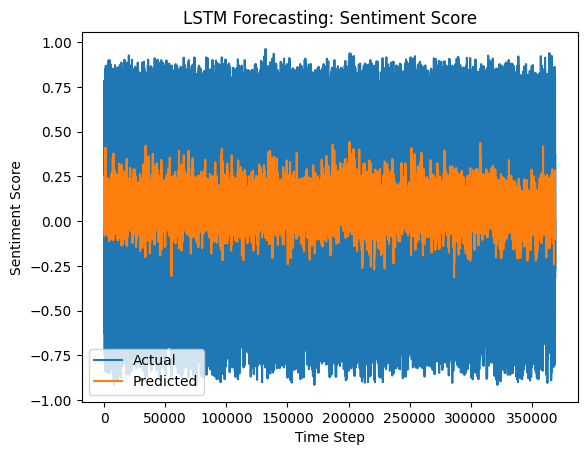

In [43]:
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.title("LSTM Forecasting: Sentiment Score")
plt.xlabel("Time Step")
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()